# Make Spice Anomaly Maps

Serves issue #6
Use the local linearization of the equation of state and the mean temperature and salinity to estimate spice anomalies.

Will require some interpolation routine that takes from depth to density space and back.



In [1]:
import numpy as np
import xarray as xr 

import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm
import glidertools as gt

from cmocean import cm as cmo

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [4]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [9]:
# easier to work with a days variable that is a float rather than datenum
days = ds_659.time - np.datetime64('2019-01-01')
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [6]:
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                                 ds_659.pressure, 
                                                 ds_659.latitude, 
                                                 ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                                 ds_660.pressure,
                                                 ds_660.latitude, 
                                                 ds_660.longitude)
ds_659['spice'] = gt.physics.spice0(ds_659.salinity, 
                         ds_659.temperature, 
                         ds_659.pressure, 
                         ds_659.latitude, 
                         ds_659.longitude)

ds_660['spice'] = gt.physics.spice0(ds_660.salinity, 
                         ds_660.temperature, 
                         ds_660.pressure, 
                         ds_660.latitude, 
                         ds_660.longitude)

In [ ]:
# make some sections of spice in pressure vs time (scatter)
# make some sections of spice in density vs time (scatter)
# since making scatter plots, no worries about gridding or anything


There are a large number of points to plot (1348609). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(49.5, 0.5, 'Pressure')

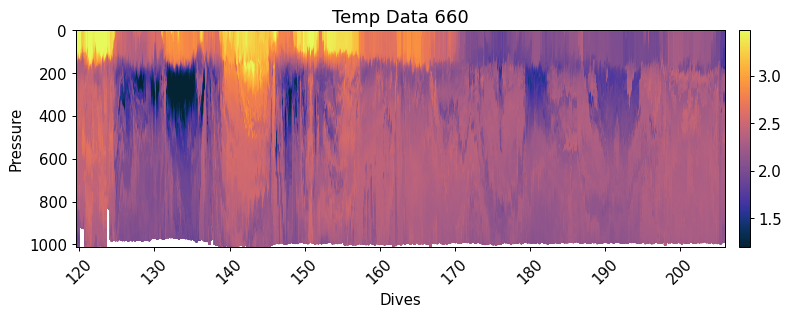

In [18]:
gt.plot.scatter(ds_660.days,
                ds_660.pressure,
                ds_660.temperature,
        cmap=cmo.thermal, robust=True, s=1)
plt.title('Temp Data 660')
plt.ylabel('Pressure')

There are a large number of points to plot (1277201). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(35.25, 0.5, 'Density')

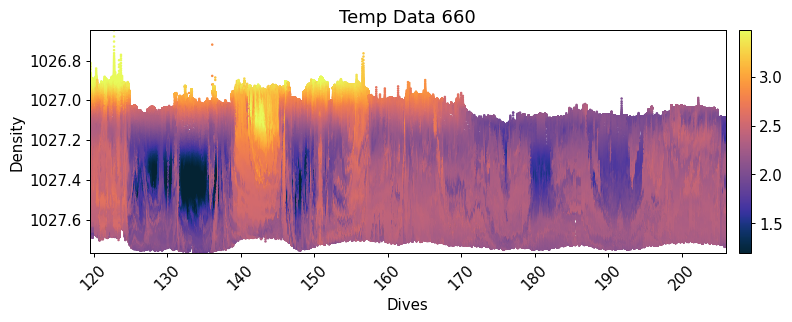

In [16]:
gt.plot.scatter(ds_660.days,
                ds_660.potdens,
                ds_660.temperature,
                cmap=cmo.thermal, robust=True, s=1)
plt.title('Temp Data 660')
plt.ylabel('Density')

In [40]:
# Interpolate and grid glider data on pressure-time axis
# There are many ways this can be done. We choose a simple linear interpolation in time and pressure
# We could alternatively interpolate in density-time, pressure-distance, dive-pressure etc.
# This a place where a lot of more work into GP and 
# learning the most optimal interpolation (in sense of MLE) might work. 

# Note this is different from what glidertools does, which does a simple binning. 

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

def interp_dens_time(ds_glid, var): 
    dens_ug = ds_glid.potdens
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, dens_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    dens_grid = np.linspace(1026.8,1027.8,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_d, grid_t = np.meshgrid(dens_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_d), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["potdens", "time"],
                          coords={"potdens":dens_grid,
                                    "time":time_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

def convert_glider_dens(ds_glid, vars_convert= ['temperature','salinity','pressure','spice']):
       
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_dens_time(ds_glid, v)
    
    return ds_grid

In [10]:
# convert from point data to gridded data, can take some time
ds_659_grid = convert_glider(ds_659)
ds_660_grid = convert_glider(ds_660)

In [41]:
ds_659_iso = convert_glider_dens(ds_659)


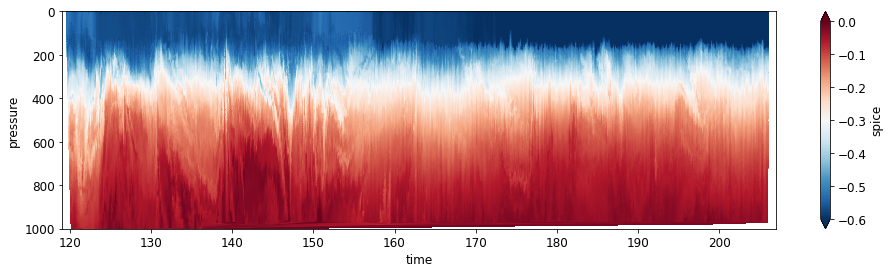

In [35]:
plt.figure(figsize=(16,4))
(ds_659_grid.spice ).plot(vmin=-0.6, vmax=0, cmap='RdBu_r')
plt.gca().invert_yaxis()

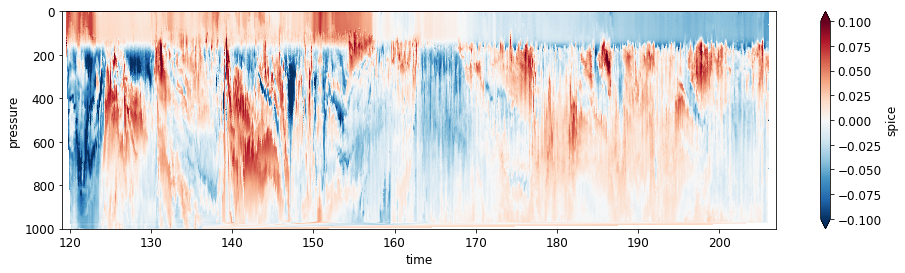

In [33]:
plt.figure(figsize=(16,4))
(ds_659_grid.spice -ds_659_grid.spice.mean('time')).plot(vmin=-0.1)
plt.gca().invert_yaxis()

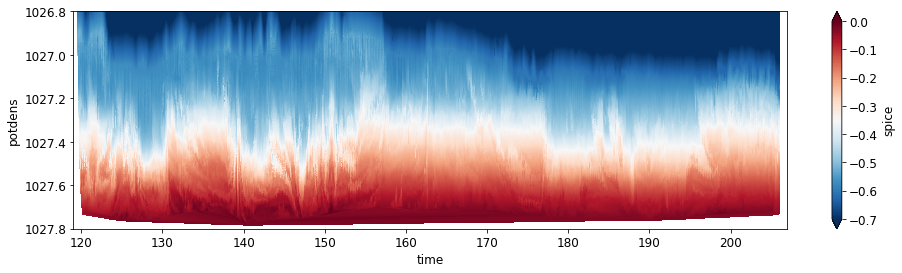

In [45]:
plt.figure(figsize=(16,4))
(ds_659_iso.spice ).plot(vmin=-0.7, vmax=0, cmap='RdBu_r')
plt.gca().invert_yaxis()

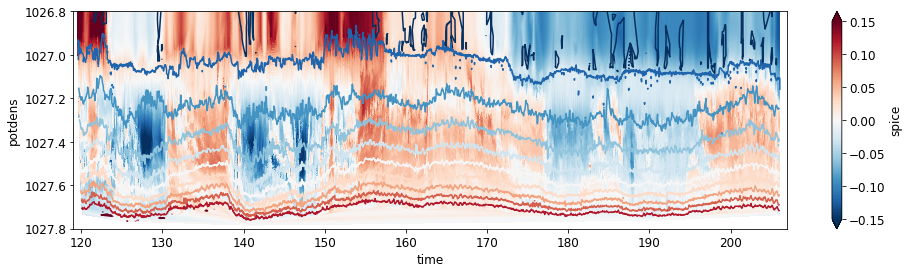

In [53]:
plt.figure(figsize=(16,4))
(ds_659_iso.spice - ds_659_iso.spice.mean('time') ).plot(vmin=-0.15,  cmap='RdBu_r')
(ds_659_iso.pressure).plot.contour(levels=np.linspace(0,1000, 11))

plt.gca().invert_yaxis()

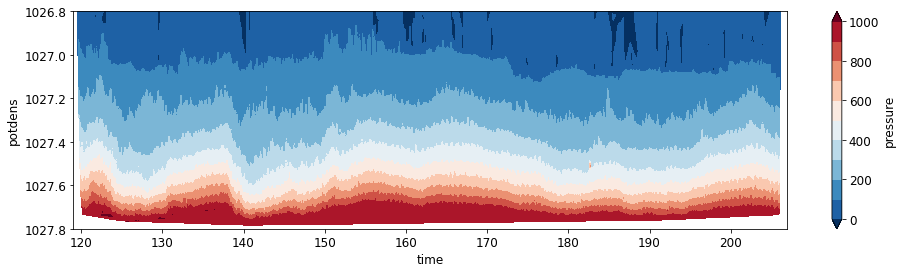

In [49]:
plt.figure(figsize=(16,4))
(ds_659_iso.pressure).plot.contourf(levels=np.linspace(0,1000, 11))
plt.gca().invert_yaxis()

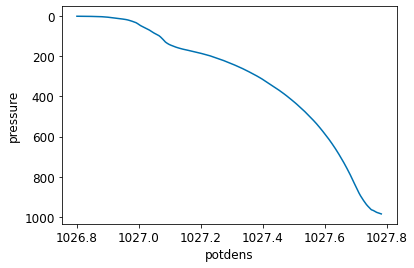

In [56]:
ds_659_iso.pressure.mean('time').plot()
plt.gca().invert_yaxis()

In [70]:
meanp = ds_659_iso.pressure.mean('time')
meanp_dropped = meanp.where(~np.isnan(meanp), drop=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


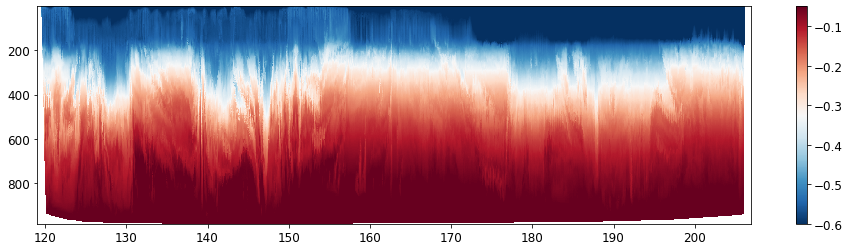

In [80]:
plt.figure(figsize=(16,4))
plt.pcolormesh(ds_659_iso.time, meanp_dropped, 
               ds_659_iso.spice.sel(potdens = meanp_dropped.potdens), cmap='RdBu_r',
              vmin=-0.6, vmax=-0.05)
plt.gca().invert_yaxis()
plt.colorbar()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


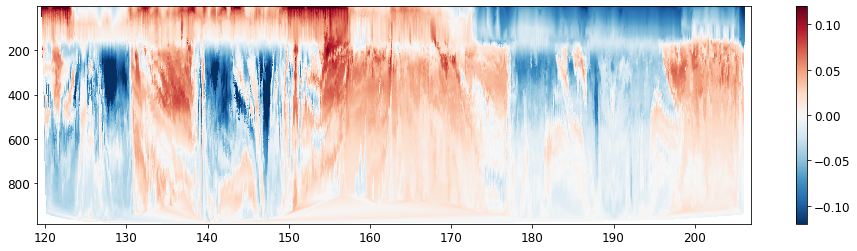

In [76]:
plt.figure(figsize=(16,4))
plt.pcolormesh(ds_659_iso.time, meanp_dropped, 
               (ds_659_iso.spice - ds_659_iso.spice.mean('time')).sel(potdens = meanp_dropped.potdens), 
               cmap='RdBu_r', vmin=-0.12, vmax=0.12)
plt.colorbar()
plt.gca().invert_yaxis()